In [2]:
import pandas as pd
import numpy as np
import duckdb
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from modelling_utils import get_abt_estacoes_vizinhas,split_com_sem_vizinha,particao_por_estacao,feature_selection,undersample_zeros
from metrics import precision,recall,F_score,R2_determinacao,RMSE,MAE,PSC_A,PCC_A,PMC_A
from sklearn.ensemble import RandomForestRegressor
from tqdm.notebook import tqdm
modelling_conn = duckdb.connect('modelling_db')
modelling_conn.execute("SET memory_limit = '16GB'")
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Testando múltiplos parâmetros

In [6]:
from metrics import precision,recall,F_score,R2_determinacao,RMSE,MAE,PSC_A,PCC_A,PMC_A
percent_datetime_partitioning_split = 0.7

relative_error_threshold = 0.1
absolute_error_threshold = 5
min_sem_chuva = 1
min_relevancia = 0.5
beta = 1
minimo_muita_chuva = 20

key_columns = ['latitude','longitude','dt_medicao_mes', 'dt_medicao_ano']
geo_columns = ['vl_declividade', 'vl_altitude', 'vl_distancia_oceano', 'vl_aspecto_relevo']
local_vars_columns = ['vl_temperatura_maxima', 'vl_temperatura_media','vl_temperatura_minima', 'vl_umidade_relativa_maxima','vl_umidade_relativa_media', 'vl_umidade_relativa_minima','vl_velocidade_vento_2m_maxima', 'vl_velocidade_vento_2m_media','vl_velocidade_vento_10m_media']
chirps_columns = ['vl_precipitacao_chirps']
cpc_columns = ['vl_precipitacao_cpc', 'vl_temperatura_maxima_cpc','vl_temperatura_minima_cpc']
gpm_final_run_columns = ['vl_precipitacao_gpm_final_run']
gpm_late_run_columns = ['vl_precipitacao_gpm_late_run']
power_columns = ['vl_precipitacao_power','vl_temperatura_maxima_2m_K_power', 'vl_temperatura_media_2m_K_power','vl_temperatura_minima_2m_K_power', 'vl_umidade_relativa_2m_power','vl_pressao_nivel_superficie_power', 'vl_irradiancia_allsky_power','vl_direcao_vento_10m_power','vl_direcao_vento_2m_power','vl_temperatura_orvalho_2m_K_power', 'vl_vento_10m_power','vl_vento_medio_2m_power', 'vl_vento_maximo_2m_power','vl_vento_maximo_10m_power']
estacao_vizinha_columns = ['vl_precipitacao_vizinha','vl_prioridade_vizinha']
target = 'vl_precipitacao'
produtos_columns = chirps_columns+cpc_columns+gpm_final_run_columns+gpm_late_run_columns+power_columns

featurelist_com_vizinha = key_columns + geo_columns + local_vars_columns + produtos_columns + estacao_vizinha_columns
featurelist_sem_vizinha = key_columns + geo_columns + local_vars_columns + produtos_columns

abt_estacoes_vizinhas = get_abt_estacoes_vizinhas(modelling_conn=modelling_conn)

model_params = {}

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [7]:
resultados = []

for threshold in tqdm(np.arange(0.4, 0.91, 0.05), desc='Threshold Loop'):
    abt_com_vizinha, abt_sem_vizinha = split_com_sem_vizinha(abt_estacoes_vizinhas, threshold)

    # Particionar por estação
    treino_com, valid_com = particao_por_estacao(abt_com_vizinha, percent_datetime_partitioning_split)
    treino_sem, valid_sem = particao_por_estacao(abt_sem_vizinha, percent_datetime_partitioning_split)

    # Feature selection
    X_treino_com, y_treino_com = feature_selection(treino_com, featurelist_com_vizinha, target)
    X_valid_com, y_valid_com = feature_selection(valid_com, featurelist_com_vizinha, target)

    X_treino_sem, y_treino_sem = feature_selection(treino_sem, featurelist_sem_vizinha, target)
    X_valid_sem, y_valid_sem = feature_selection(valid_sem, featurelist_sem_vizinha, target)

    # Treinar modelos
    modelo_com = XGBRegressor(**model_params)
    modelo_sem = XGBRegressor(**model_params)

    modelo_com.fit(X_treino_com, y_treino_com)
    modelo_sem.fit(X_treino_sem, y_treino_sem)

    # Previsões
    y_pred_com = modelo_com.predict(X_valid_com)
    y_pred_sem = modelo_sem.predict(X_valid_sem)

    # Calcular métricas e salvar
    resultados.append({
        'threshold_prioridade': threshold,
        'tipo': 'com_vizinha',
        'precision': precision(y_valid_com, y_pred_com, error_threshold=relative_error_threshold, min_relevancia=min_relevancia),
        'recall': recall(y_valid_com, y_pred_com, error_threshold=relative_error_threshold, min_relevancia=min_relevancia),
        'F1-Score': F_score(y_valid_com, y_pred_com, beta=beta, error_threshold=relative_error_threshold, min_relevancia=min_relevancia),
        'RMSE': RMSE(y_valid_com, y_pred_com),
        'R2': R2_determinacao(y_valid_com, y_pred_com),
        'MAE': MAE(y_valid_com, y_pred_com),
        'PSC_A': PSC_A(y_valid_com, y_pred_com, erro=min_sem_chuva),
        'PCC_A': PCC_A(y_valid_com, y_pred_com, erro=absolute_error_threshold),
        'PMC_A': PMC_A(y_valid_com, y_pred_com, erro=absolute_error_threshold, chuva_minima=minimo_muita_chuva)
    })

    resultados.append({
        'threshold_prioridade': threshold,
        'tipo': 'sem_vizinha',
        'precision': precision(y_valid_sem, y_pred_sem, error_threshold=relative_error_threshold, min_relevancia=min_relevancia),
        'recall': recall(y_valid_sem, y_pred_sem, error_threshold=relative_error_threshold, min_relevancia=min_relevancia),
        'F1-Score': F_score(y_valid_sem, y_pred_sem, beta=beta, error_threshold=relative_error_threshold, min_relevancia=min_relevancia),
        'RMSE': RMSE(y_valid_sem, y_pred_sem),
        'R2': R2_determinacao(y_valid_sem, y_pred_sem),
        'MAE': MAE(y_valid_sem, y_pred_sem),
        'PSC_A': PSC_A(y_valid_sem, y_pred_sem, erro=min_sem_chuva),
        'PCC_A': PCC_A(y_valid_sem, y_pred_sem, erro=absolute_error_threshold),
        'PMC_A': PMC_A(y_valid_sem, y_pred_sem, erro=absolute_error_threshold, chuva_minima=minimo_muita_chuva)
    })

# Converter para DataFrame
df_resultados = pd.DataFrame(resultados)

Threshold Loop:   0%|          | 0/11 [00:00<?, ?it/s]

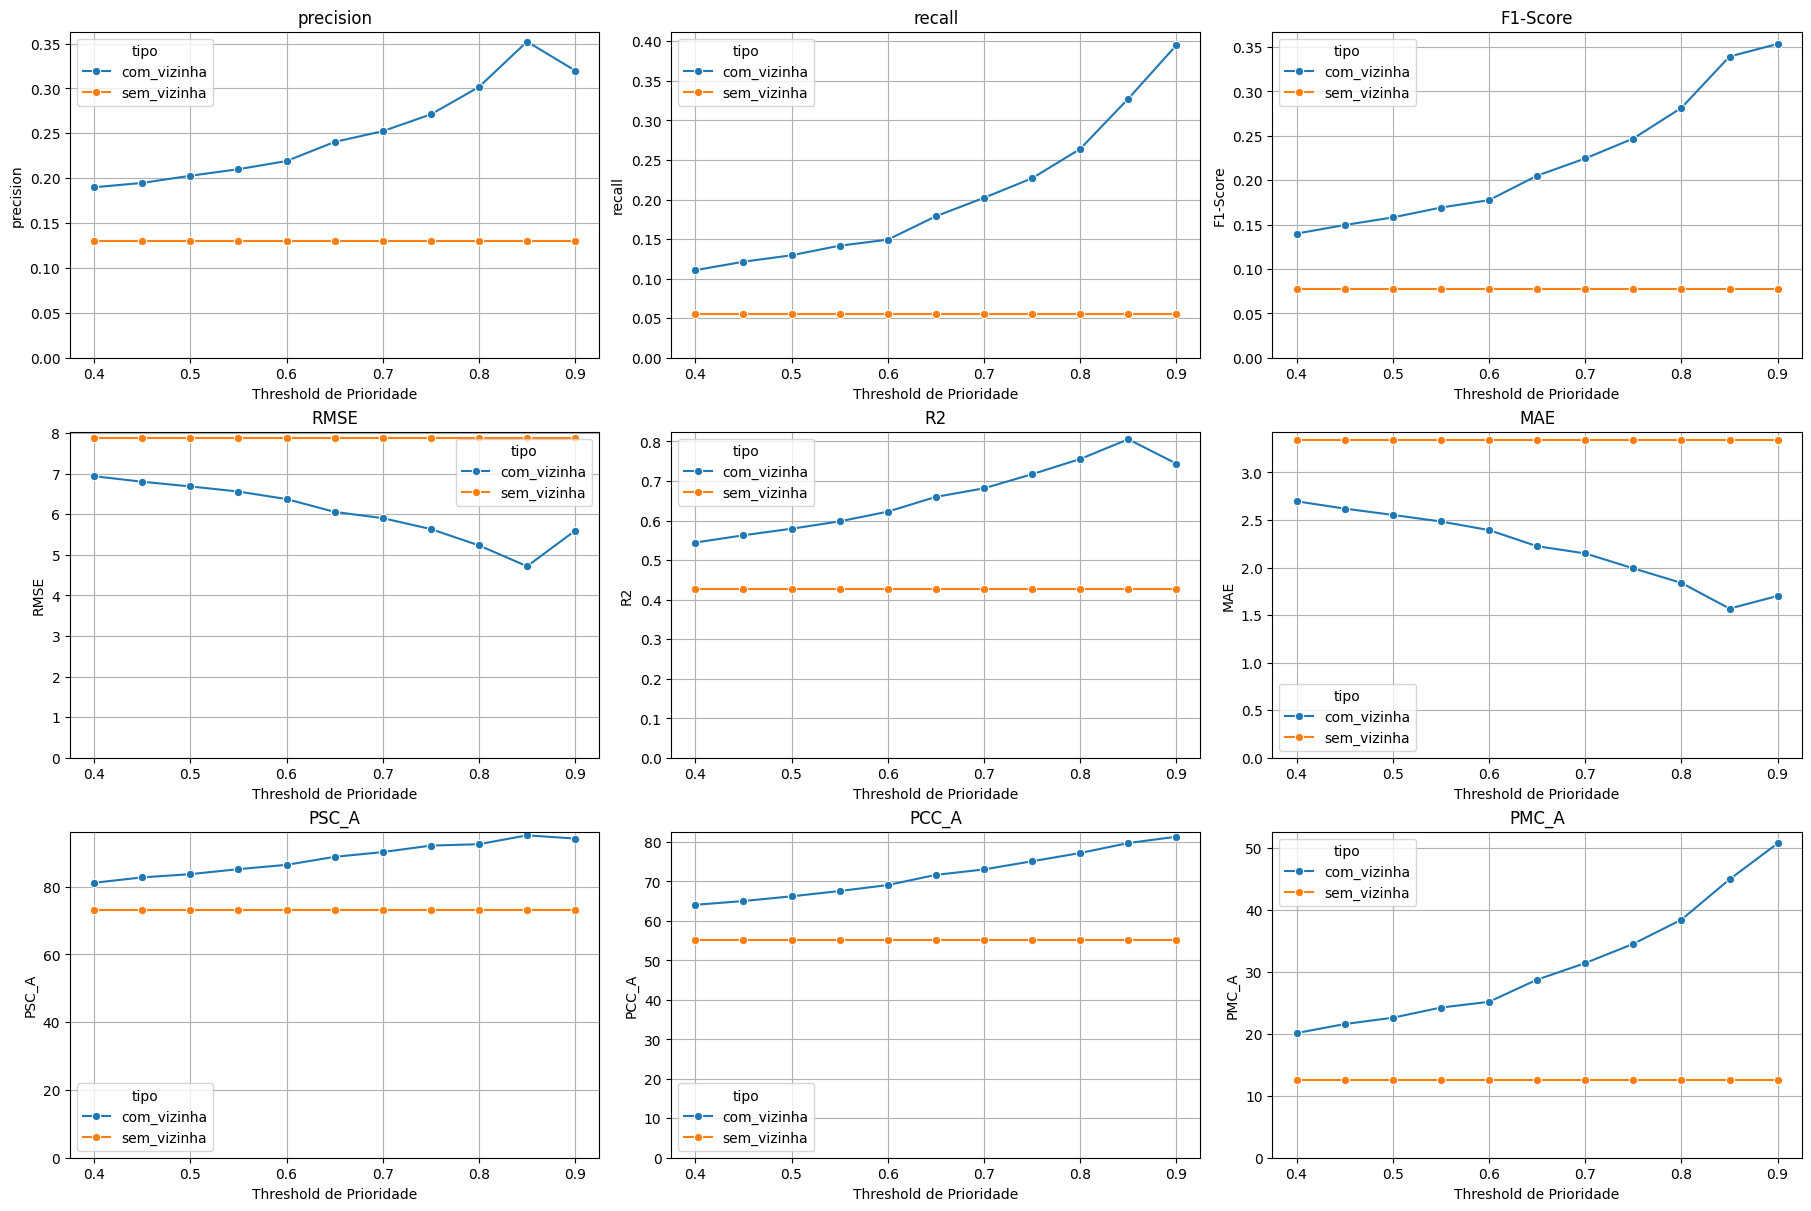

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Lista de métricas que você quer plotar
metricas = ['precision', 'recall', 'F1-Score', 'RMSE', 'R2', 'MAE', 'PSC_A', 'PCC_A', 'PMC_A']

# Tamanho da figura (ajuste conforme necessário)
n_rows = (len(metricas) + 2) // 3
fig, axes = plt.subplots(n_rows, 3, figsize=(18, 4 * n_rows), constrained_layout=True)

# Achatar os eixos para iterar facilmente
axes = axes.flatten()

for i, metrica in enumerate(metricas):
    ax = axes[i]
    sns.lineplot(
        data=df_resultados,
        x='threshold_prioridade',
        y=metrica,
        hue='tipo',
        marker='o',
        ax=ax
    )
    ax.set_title(metrica)
    ax.grid(True)
    ax.set_xlabel('Threshold de Prioridade')
    ax.set_ylabel(metrica)
    ax.set_ylim(0)

# Remover plots extras se sobrar eixo
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
plt.savefig('metricas_por_threshold_de_prioridade_XGBoost.png')
plt.show()



In [ ]:
# PROXIMOS PASSOS:
# > Testar Random Forest
# > Analise de relevancia de variaveis (talvez PCA?)
# > OK Implementar métricas personalizadas
# > Testar undersampling
# > Testar oversampling (com smoteR)
# > Testar preenchimento de dados faltantes

# Testando apenas um Parâmetro

In [3]:
percent_datetime_partitioning_split = 0.7

relative_error_threshold = 0.1
absolute_error_threshold = 5
min_sem_chuva = 1
min_relevancia = 0.5
beta = 1
minimo_muita_chuva = 20

key_columns = ['latitude','longitude','dt_medicao_mes', 'dt_medicao_ano']
geo_columns = ['vl_declividade', 'vl_altitude', 'vl_distancia_oceano', 'vl_aspecto_relevo']
local_vars_columns = ['vl_temperatura_maxima', 'vl_temperatura_media','vl_temperatura_minima', 'vl_umidade_relativa_maxima','vl_umidade_relativa_media', 'vl_umidade_relativa_minima','vl_velocidade_vento_2m_maxima', 'vl_velocidade_vento_2m_media','vl_velocidade_vento_10m_media']
chirps_columns = ['vl_precipitacao_chirps']
cpc_columns = ['vl_precipitacao_cpc', 'vl_temperatura_maxima_cpc','vl_temperatura_minima_cpc']
gpm_final_run_columns = ['vl_precipitacao_gpm_final_run']
gpm_late_run_columns = ['vl_precipitacao_gpm_late_run']
power_columns = ['vl_precipitacao_power','vl_temperatura_maxima_2m_K_power', 'vl_temperatura_media_2m_K_power','vl_temperatura_minima_2m_K_power', 'vl_umidade_relativa_2m_power','vl_pressao_nivel_superficie_power', 'vl_irradiancia_allsky_power','vl_direcao_vento_10m_power','vl_direcao_vento_2m_power','vl_temperatura_orvalho_2m_K_power', 'vl_vento_10m_power','vl_vento_medio_2m_power', 'vl_vento_maximo_2m_power','vl_vento_maximo_10m_power']
estacao_vizinha_columns = ['vl_precipitacao_vizinha','vl_prioridade_vizinha']
target = 'vl_precipitacao'
produtos_columns = chirps_columns+cpc_columns+gpm_final_run_columns+gpm_late_run_columns+power_columns

featurelist_com_vizinha = key_columns + geo_columns + local_vars_columns + produtos_columns + estacao_vizinha_columns
featurelist_sem_vizinha = key_columns + geo_columns + local_vars_columns + produtos_columns

abt_estacoes_vizinhas = get_abt_estacoes_vizinhas(modelling_conn=modelling_conn)

model_params = {}

Model = XGBRegressor

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [4]:
abt_estacoes_vizinhas.to_csv('abt_estacoes_vizinhas.csv',index=False)

In [6]:
abt_estacoes_vizinhas.to_parquet('abt_estacoes_vizinhas.parquet',index=False)

## Sem separação de com e sem vizinha

In [14]:
metricas = []

### Sem Undersampling

In [15]:
treinamento,validacao = particao_por_estacao(abt_estacoes_vizinhas,percent_datetime_partitioning_split)

X_treino,y_treino = feature_selection(treinamento,featurelist_com_vizinha,target)
X_validacao,y_validacao = feature_selection(validacao,featurelist_com_vizinha,target)

current_model = Model()
current_model.fit(X_treino, y_treino)
y_pred = current_model.predict(X_validacao)

metricas.append({
    'sampling':'Nenhum',
    'precision':precision(y_validacao,y_pred,error_threshold=relative_error_threshold,min_relevancia=min_relevancia),
    'recall':recall(y_validacao,y_pred,error_threshold=relative_error_threshold,min_relevancia=min_relevancia),
    'F1-Score':F_score(y_validacao,y_pred,beta=beta,error_threshold=relative_error_threshold,min_relevancia=min_relevancia),
    'RMSE':RMSE(y_validacao,y_pred),
    'R2':R2_determinacao(y_validacao,y_pred),
    'MAE':MAE(y_validacao,y_pred),
    'PSC_A':PSC_A(y_validacao,y_pred,erro=min_sem_chuva),
    'PCC_A':PCC_A(y_validacao,y_pred,erro=absolute_error_threshold),
    'PMC_A':PMC_A(y_validacao,y_pred,erro=absolute_error_threshold,chuva_minima=minimo_muita_chuva)
})

### Com UnderSampling

In [17]:
zero_ratios = [1.0, 2.0, 3.0] 

treinamento, validacao = particao_por_estacao(abt_estacoes_vizinhas, percent_datetime_partitioning_split)
X_validacao, y_validacao = feature_selection(validacao, featurelist_com_vizinha, target)

for zr in zero_ratios:
    X_pre, y_pre = feature_selection(treinamento, featurelist_com_vizinha, target)
    X_treino, y_treino = undersample_zeros(X_pre, y_pre, zero_ratio=zr)

    current_model = Model()
    current_model.fit(X_treino, y_treino)
    y_pred = current_model.predict(X_validacao)

    metricas.append({
        'sampling': f'UnderSampling ratio={zr}',
        'precision': precision(y_validacao, y_pred, error_threshold=relative_error_threshold, min_relevancia=min_relevancia),
        'recall': recall(y_validacao, y_pred, error_threshold=relative_error_threshold, min_relevancia=min_relevancia),
        'F1-Score': F_score(y_validacao, y_pred, beta=beta, error_threshold=relative_error_threshold, min_relevancia=min_relevancia),
        'RMSE': RMSE(y_validacao, y_pred),
        'R2': R2_determinacao(y_validacao, y_pred),
        'MAE': MAE(y_validacao, y_pred),
        'PSC_A': PSC_A(y_validacao, y_pred, erro=min_sem_chuva),
        'PCC_A': PCC_A(y_validacao, y_pred, erro=absolute_error_threshold),
        'PMC_A': PMC_A(y_validacao, y_pred, erro=absolute_error_threshold, chuva_minima=minimo_muita_chuva)
    })

df_metricas = pd.DataFrame(metricas)
print(df_metricas)


                  sampling  precision    recall  F1-Score      RMSE        R2  \
0                   Nenhum   0.186857  0.107983  0.136870  7.071591  0.537435   
1  UnderSampling ratio=1.0   0.182647  0.113860  0.140275  7.131620  0.529548   
2  UnderSampling ratio=1.5   0.186225  0.111288  0.139319  7.091786  0.534789   
3  UnderSampling ratio=2.0   0.185197  0.107023  0.135654  7.083417  0.535887   
4  UnderSampling ratio=3.0   0.186374  0.106698  0.135705  7.083933  0.535819   
5  UnderSampling ratio=5.0   0.186374  0.106698  0.135705  7.083933  0.535819   
6  UnderSampling ratio=1.0   0.182647  0.113860  0.140275  7.131620  0.529548   
7  UnderSampling ratio=2.0   0.185197  0.107023  0.135654  7.083417  0.535887   
8  UnderSampling ratio=3.0   0.186374  0.106698  0.135705  7.083933  0.535819   

        MAE      PSC_A      PCC_A      PMC_A  
0  2.812028  79.337319  62.431027  19.705128  
1  3.090018  70.832960  61.385373  21.040946  
2  2.930520  75.676065  61.930160  20.293783  
3

## Com separação de com e sem vizinha

In [ ]:
key_columns = ['latitude','longitude','dt_medicao_mes', 'dt_medicao_ano']
geo_columns = ['vl_declividade', 'vl_altitude', 'vl_distancia_oceano', 'vl_aspecto_relevo']
local_vars_columns = ['vl_temperatura_maxima', 'vl_temperatura_media','vl_temperatura_minima', 'vl_umidade_relativa_maxima','vl_umidade_relativa_media', 'vl_umidade_relativa_minima','vl_velocidade_vento_2m_maxima', 'vl_velocidade_vento_2m_media','vl_velocidade_vento_10m_media']
chirps_columns = ['vl_precipitacao_chirps']
cpc_columns = ['vl_precipitacao_cpc', 'vl_temperatura_maxima_cpc','vl_temperatura_minima_cpc']
gpm_final_run_columns = ['vl_precipitacao_gpm_final_run']
gpm_late_run_columns = ['vl_precipitacao_gpm_late_run']
power_columns = ['vl_precipitacao_power','vl_temperatura_maxima_2m_K_power', 'vl_temperatura_media_2m_K_power','vl_temperatura_minima_2m_K_power', 'vl_umidade_relativa_2m_power','vl_pressao_nivel_superficie_power', 'vl_irradiancia_allsky_power','vl_direcao_vento_10m_power','vl_direcao_vento_2m_power','vl_temperatura_orvalho_2m_K_power', 'vl_vento_10m_power','vl_vento_medio_2m_power', 'vl_vento_maximo_2m_power','vl_vento_maximo_10m_power']
estacao_vizinha_columns = ['vl_precipitacao_vizinha','vl_prioridade_vizinha']
target = 'vl_precipitacao'
produtos_columns = chirps_columns+cpc_columns+gpm_final_run_columns+gpm_late_run_columns+power_columns

featurelist_com_vizinha = key_columns + geo_columns + local_vars_columns + produtos_columns + estacao_vizinha_columns
featurelist_sem_vizinha = key_columns + geo_columns + local_vars_columns + produtos_columns

In [ ]:
threshold_prioridade = 0.5
percent_datetime_partitioning_split = 0.7

abt_estacoes_vizinhas = get_abt_estacoes_vizinhas(modelling_conn=modelling_conn)

# model_params = {
#     "tree_method": "hist",
#     "device": "cuda"
# }

model_params = {}

abt_com_vizinha,abt_sem_vizinha = split_com_sem_vizinha(abt_estacoes_vizinhas,threshold_prioridade)

treinamento_com_vizinha,validacao_com_vizinha = particao_por_estacao(abt_com_vizinha,percent_datetime_partitioning_split)
treinamento_sem_vizinha,validacao_sem_vizinha = particao_por_estacao(abt_sem_vizinha,percent_datetime_partitioning_split)

X_com_vizinha_treino,y_com_vizinha_treino = feature_selection(treinamento_com_vizinha,featurelist_com_vizinha,target)
X_sem_vizinha_treino,y_sem_vizinha_treino = feature_selection(treinamento_sem_vizinha,featurelist_sem_vizinha,target)
X_com_vizinha_validacao,y_com_vizinha_validacao = feature_selection(validacao_com_vizinha,featurelist_com_vizinha,target)
X_sem_vizinha_validacao,y_sem_vizinha_validacao = feature_selection(validacao_sem_vizinha,featurelist_sem_vizinha,target)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [ ]:
Model = XGBRegressor    

model_com_vizinha = Model(**model_params)
model_sem_vizinha = Model(**model_params)

model_com_vizinha.fit(X_com_vizinha_treino, y_com_vizinha_treino)
model_sem_vizinha.fit(X_sem_vizinha_treino, y_sem_vizinha_treino)

y_com_vizinha_pred = model_com_vizinha.predict(X_com_vizinha_validacao)
y_sem_vizinha_pred = model_sem_vizinha.predict(X_sem_vizinha_validacao)

In [ ]:
from metrics import precision,recall,F_score,R2_determinacao,RMSE,MAE,PSC_A,PCC_A,PMC_A

relative_error_threshold = 0.1
absolute_error_threshold = 5
min_sem_chuva = 1
min_relevancia = 0.5
beta = 1
minimo_muita_chuva = 20

metrics = {
    'precision':precision(y_com_vizinha_validacao,y_com_vizinha_pred,error_threshold=relative_error_threshold,min_relevancia=min_relevancia),
    'recall':recall(y_com_vizinha_validacao,y_com_vizinha_pred,error_threshold=relative_error_threshold,min_relevancia=min_relevancia),
    'F1-Score':F_score(y_com_vizinha_validacao,y_com_vizinha_pred,beta=beta,error_threshold=relative_error_threshold,min_relevancia=min_relevancia),
    'RMSE':RMSE(y_com_vizinha_validacao,y_com_vizinha_pred),
    'R2':R2_determinacao(y_com_vizinha_validacao,y_com_vizinha_pred),
    'MAE':MAE(y_com_vizinha_validacao,y_com_vizinha_pred),
    'PSC_A':PSC_A(y_com_vizinha_validacao,y_com_vizinha_pred,erro=min_sem_chuva),
    'PCC_A':PCC_A(y_com_vizinha_validacao,y_com_vizinha_pred,erro=absolute_error_threshold),
    'PMC_A':PMC_A(y_com_vizinha_validacao,y_com_vizinha_pred,erro=absolute_error_threshold,chuva_minima=minimo_muita_chuva)
}